In [1]:
from IPython.display import display, clear_output
import numpy as np
import pyopencl as cl
from PIL import Image
import time
import signal

In [2]:
signal_done = False

def signal_handler(signal, frame):
    global signal_done
    signal_done = True

def stop_on_signal():
    global signal_done
    signal_done = False
    signal.signal(signal.SIGINT, signal_handler)

In [3]:
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)
mf = cl.mem_flags

In [4]:
class Buffer:
    def __init__(self, nparray, ro=False, dual=False):
        self.ro = ro
        self.dual = dual
        self.host = nparray
        flags = 0
        if ro:
            flags |= mf.READ_ONLY
        else:
            flags |= mf.READ_WRITE
        mkbuf = lambda buf: cl.Buffer(ctx, flags | mf.COPY_HOST_PTR, hostbuf=buf)
        self.buf = mkbuf(self.host)
        if dual:
            self.dbuf = mkbuf(self.host)
    
    def swap(self):
        if self.dual:
            self.buf, self.dbuf = self.dbuf, self.buf
    
    def load(self):
        cl.enqueue_copy(queue, self.host, self.buf)

In [5]:
with open("simple-rnn.cl", "r") as f:
    program = cl.Program(ctx, f.read()).build()

In [6]:
class World:
    def __init__(self, size, n_agents, param):
        self.size = size
        self.n_agents = (n_agents,)
        self.param = param
        
        self.w_shape = (size[1], size[0])
        self.a_shape = (n_agents,)
        
        self.buffers = {}
        
        # screen
        self.buffers["w_screen"] = Buffer(np.zeros((*self.w_shape, 3), dtype=np.uint8))
        
        # random
        self.buffers["a_random"] = Buffer(np.random.randint(1<<32, size=self.a_shape, dtype=np.uint32))
        self.buffers["w_random"] = Buffer(np.random.randint(1<<32, size=self.w_shape, dtype=np.uint32))
        
        # trace
        self.buffers["w_trace"] = Buffer(np.zeros(self.w_shape, dtype=np.float32), dual=True)
        
        # agents
        a_x = np.random.randint(0, self.size[0], size=self.a_shape)
        a_y = np.random.randint(0, self.size[1], size=self.a_shape)
        a_score = np.zeros(self.a_shape)
        self.buffers["a_agents_i"] = Buffer(np.stack((a_x, a_y, a_score), axis=1).astype(np.int32))
        self.buffers["a_agents_f"] = Buffer(np.zeros((*self.a_shape, 1), dtype=np.float32))
        
        # parameters
        self.buffers["PAR_I"] = Buffer(np.array([
            self.size[0],
            self.size[1],
            self.buffers["a_agents_i"].host.shape[-1],
            self.buffers["a_agents_f"].host.shape[-1],
        ], dtype=np.int32), ro=True)
        self.buffers["PAR_F"] = Buffer(np.array([
            self.param["trace_fade_factor"],
            self.param["trace_diffusion_factor"],
        ], dtype=np.float32), ro=True)
        
    def step(self):
        program.w_step(
            queue,
            self.size,
            None,
            
            self.buffers["PAR_I"].buf,
            self.buffers["PAR_F"].buf,
            
            self.buffers["w_random"].buf,
            
            self.buffers["w_trace"].buf,
            self.buffers["w_trace"].dbuf,
        )
        
        program.a_step(
            queue,
            self.n_agents,
            None,
            
            self.buffers["PAR_I"].buf,
            self.buffers["PAR_F"].buf,
            
            self.buffers["a_random"].buf,
            
            self.buffers["a_agents_i"].buf,
            self.buffers["a_agents_f"].buf,
            
            self.buffers["w_trace"].buf,
            self.buffers["w_trace"].dbuf,
        )
        
        for buf in self.buffers.values():
            if buf.dual:
                buf.swap()
        
    def draw(self):
        program.w_draw(
            queue,
            self.size,
            None,
            
            self.buffers["PAR_I"].buf,
            self.buffers["PAR_F"].buf,
            
            self.buffers["w_trace"].buf,
            self.buffers["w_screen"].buf,
        )
        
        program.a_draw(
            queue,
            self.n_agents,
            None,
            
            self.buffers["PAR_I"].buf,
            self.buffers["PAR_F"].buf,
            
            self.buffers["a_agents_i"].buf,
            self.buffers["a_agents_f"].buf,
            
            self.buffers["w_screen"].buf,
        )
        self.buffers["w_screen"].load()
        return self.buffers["w_screen"].host

In [7]:
world = World((800, 600), 256, param={
    "trace_fade_factor": 0.001,
    "trace_diffusion_factor": 0.001,
})

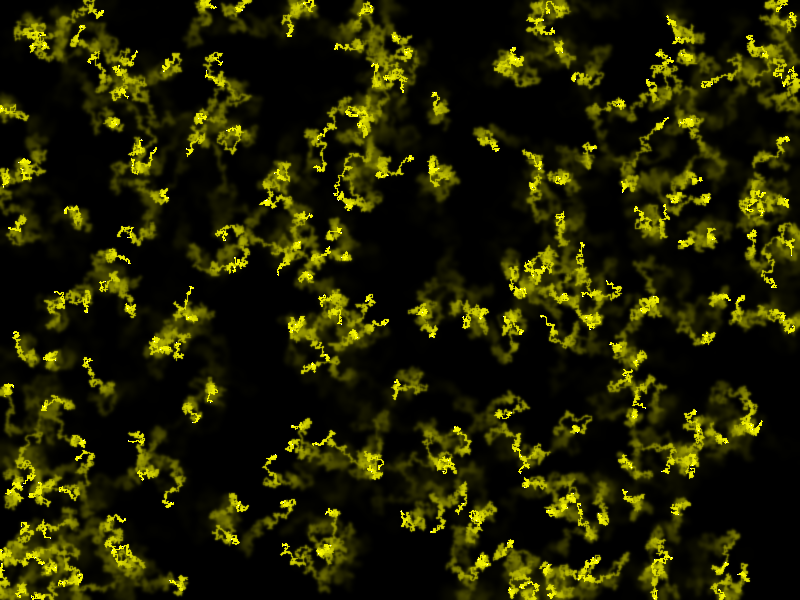

steps elapsed: 10083


In [8]:
stop_on_signal()
last = time.time()
n_steps = 0
while not signal_done:
    world.step()
    n_steps += 1
    now = time.time()
    if now - last >= 2.0:
        clear_output(wait=True)
        display(Image.fromarray(world.draw()))
        print("steps elapsed: %s" % n_steps)
        last = now

In [28]:
from skvideo.io import FFmpegWriter
from IPython.display import HTML
import base64
import io

In [29]:
params = {
    "-vcodec": "libx264",
    "-pix_fmt": "yuv420p",
    "-profile:v": "baseline",
    "-level": "3"
}
video = FFmpegWriter("tmp.mp4", outputdict=params)
stride = 10
for i in range(10*24):
    for j in range(stride):
        world.step()
    img = world.draw()
    video.writeFrame(img)
video.close()

In [ ]:
with open("tmp.mp4", "rb") as f:
    vdata = f.read()
vbase64 = base64.b64encode(vdata).decode("ascii")
HTML('<video controls src="data:video/mp4;base64,%s" type="video/mp4" >' % vbase64)

In [37]:
np.array([[1, 2, 3],[4, 5, 6]], dtype=np.int32).view(dtype=np.uint8)

array([[1, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0],
       [4, 0, 0, 0, 5, 0, 0, 0, 6, 0, 0, 0]], dtype=uint8)